# <center> Purchasing your next house! </center>

### Libraries, credentials, and configuration

In [164]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import requests
import json
from bs4 import BeautifulSoup
import re
from geopy.geocoders import Nominatim
import pprint
import folium
from folium.features import DivIcon
import matplotlib.pyplot as plt
from IPython.display import display

# Four Square credentials
client_id = 'PEQPJEZXPG4HRTFTMTZHL3P3QRZ1SV55525PX2YO22F3Q0JB'
client_secret = 'JEDPFGTRY4SISHI1S2W3RTQGIG3UUROA5OG4I3NW4UXBBLB1'
version = '20180605'

# OpenCage Geocoding API key
my_api_key = "a91cf6a6d9ec4e6fa91deb0bc4fbf168"

# Zillow ZWSID
zwsid = "X1-ZWz1h8e56llaff_6bk45"

### Shortlisting the cities based on population

There are some good cities around Austin, but it will become a heavy task to compare and contrast each cities as there are more than 30. So, this project will be limited to top three cities with a high population in the list.

In [21]:
# Scraping the near-by cities list from wikipedia
austin_nearby = "https://en.wikipedia.org/wiki/Greater_Austin"
response = requests.get(austin_nearby)

# Parsing the results with BeautifulSoup
soup = BeautifulSoup(response.text, "html.parser")
table = soup.find_all("table", class_="wikitable")
population_table = table[1]
pop_def = population_table.find_all('td')

city_list = []
population_list = []

for i in range(0, 27, 3):
    city_list.append(pop_def[i].text.strip())
    population_list.append(pop_def[i+1].contents[0])

city_df = pd.DataFrame(columns=["CityName", "Population"])
city_df["CityName"] = city_list 
city_df["Population"] = population_list
city_df

,CityName,Population
0,Austin,"950,715"
1,Round Rock,"123,678"
2,Cedar Park,"75,704"
3,Georgetown,"70,685"
4,San Marcos,"63,071"
5,Pflugerville,"59,245"
6,Leander,"42,761"
7,Kyle,"39,060"
8,Hutto,"23,832"


As we see, the top three cities are: <strong>Austin, Round Rock, and Cedar Park</strong>. So, let's start exploring them


In [22]:
# Getting the latitude and longitude coordinates of these cities using OpenCage Geocoding APIs
city_list = ['Austin', 'Round Rock', 'Cedar Park']
latitude_list = []
longitude_list = []
top_city_df = pd.DataFrame(columns=["CityName", "Population", "Latitude", "Longitude"])

for city in city_list:
    query = city + ", TX, United States of America"
    uri = "https://api.opencagedata.com/geocode/v1/json?q={}&key={}".format(query, my_api_key)
    response = requests.get(uri).json()
    latitude_list.append(response['results'][0]['geometry']['lat'])
    longitude_list.append(response['results'][0]['geometry']['lng'])
    
top_city_df["CityName"] = city_list
top_city_df["Latitude"] = latitude_list
top_city_df["Population"] = city_df["Population"]
top_city_df["Longitude"] = longitude_list
    
top_city_df

,CityName,Population,Latitude,Longitude
0,Austin,"950,715",30.271129,-97.743700
1,Round Rock,"123,678",30.508235,-97.678893
2,Cedar Park,"75,704",30.521712,-97.827833


### Exploring the top 3 cities with respect to various attributes

For the selected three cities, we are going to explore these different aspects which could be a good starting point to consider when purchasing a house:
<ul>
    <li>Health  [Hospital, Pharmacies, Clinics, Dentist]</li>
    <li>Food  [Grocery shops, restaurants, coffee shops]</li>
    <li>Education [Elementary schools, middle schools, high schools, college/university]</li>
    <li>Entertainment  [Movie Theaters, Bars]</li>
    <li>Average prices of the house</li>
    <li>Property taxes</li>
    <li>Average HOA</li>    
</ul>

I've chosen Health, Food, and Entertainment as first three categories because that's the most we'd need to be available close-by. 

FourSquare has unique ID's for different categories of venues listed here: https://developer.foursquare.com/docs/resources/categories. We are going to use this to explore various categories around three cities. These are the high-level categories that are chosen for this analysis (and their respective category_ID's can be found in the code):
<ul>
    <li> <strong>Health</strong> - medical center, details about doctor's office, ER, hospital, medical lab, physical therapist, outdoors and recreation, health and beauty services, pharmacy etc</li>
    <li> <strong>Food</strong> - all cuisine restaurants in the world, breakfast place, coffee shops, Fruits and Vegetables store etc</li>
    <li> <strong>Education</strong> - elementary, middle, and high schools, colleges, and universities</li>
    <li> <strong>Entertainment</strong> - Arts and entertainment, museum, nightlife spot, social clubs etc.</li>


In [23]:
# defining a common class to construct the request URL used to explore venues under various categories
def requestPayload(latitude, longitude, category):
    # crafting the request url
    limit = 500      # no. of locations to return
    radius = 8050    # approx 5 miles
    url = "https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&v={}&limit={}&radius={}&ll={},{}".format(category, client_id, client_secret, version, limit, radius, latitude, longitude)
    return url      


#### 1. Health 

In [24]:
# creating a category list that has the category IDs of the all venues related to health
health_list = ["4d4b7105d754a06377d81259", "4f4528bc4b90abdf24c9de85", "4bf58dd8d48988d104941735", "56aa371be4b08b9a8d573526", "54541900498ea6ccd0202697", "4bf58dd8d48988d10f951735",
              "4bf58dd8d48988d194941735", "4bf58dd8d48988d177941735", "5744ccdfe4b0c0459246b4af", "4bf58dd8d48988d177941735"]

# creating an empty dataframe to store the results
health_dataframe = pd.DataFrame(columns=["CityName", "Venue", "Latitude", "Longitude"])
venues_list = []
latitude_list = []
longitude_list = []
city_list = []

for city in range(3):
    for category in health_list:
        response = requests.get(requestPayload(top_city_df.loc[city, "Latitude"], top_city_df.loc[city, "Longitude"], category)).json()
        for i in range(len(response['response']['venues'])):
            venues_list.append(response['response']['venues'][i]['name'])
            latitude_list.append(response['response']['venues'][i]['location']['lat'])
            longitude_list.append(response['response']['venues'][i]['location']['lng'])
            city_list.append(top_city_df.loc[city, "CityName"])
            
health_dataframe["CityName"] = city_list
health_dataframe["Venue"] = venues_list
health_dataframe["Latitude"] = latitude_list
health_dataframe["Longitude"] = longitude_list

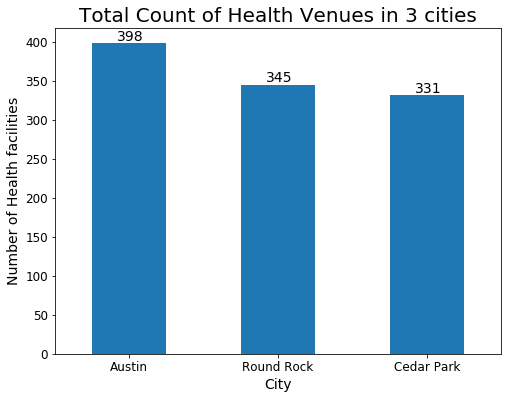

In [12]:
# plotting the health venues in three cities for easier comparison
ax = health_dataframe['CityName'].value_counts().plot(kind='bar', figsize=(8,6), fontsize=12)
ax.set_xlabel("City", fontsize=14)
plt.xticks(rotation=0)
ax.set_ylabel("Health Venues Count", fontsize=14)
plt.title("Comparison of Health Venues in 3 cities", fontsize=20)

for i in ax.patches:
    ax.text(i.get_x()+.17, i.get_height()+4.0, str(i.get_height()), fontsize=14)

#### 2. Food

In [25]:
# creating a category list that has the category IDs of the all venues related to food
food_list = [
    "4d4b7105d754a06374d81259", "4bf58dd8d48988d14e941735", "4bf58dd8d48988d142941735", "4bf58dd8d48988d111941735", 
"4bf58dd8d48988d113941735", "4eb1d5724b900d56c88a45fe", "4bf58dd8d48988d1d1941735", "4bf58dd8d48988d149941735", 
"4bf58dd8d48988d1df931735", "4bf58dd8d48988d143941735", "4bf58dd8d48988d16d941735", "4bf58dd8d48988d1e0931735", 
 "4bf58dd8d48988d147941735", "4bf58dd8d48988d16e941735"]

# creating an empty dataframe to store the results
food_dataframe = pd.DataFrame(columns=["CityName", "Venue", "Latitude", "Longitude"])
venues_list = []
latitude_list = []
longitude_list = []
city_list = []

for city in range(3):
    for category in food_list:
        response = requests.get(requestPayload(top_city_df.loc[city, "Latitude"], top_city_df.loc[city, "Longitude"], category)).json()
        for i in range(len(response['response']['venues'])):
            venues_list.append(response['response']['venues'][i]['name'])
            latitude_list.append(response['response']['venues'][i]['location']['lat'])
            longitude_list.append(response['response']['venues'][i]['location']['lng'])
            city_list.append(top_city_df.loc[city, "CityName"])
            
food_dataframe["CityName"] = city_list
food_dataframe["Venue"] = venues_list
food_dataframe["Latitude"] = latitude_list
food_dataframe["Longitude"] = longitude_list

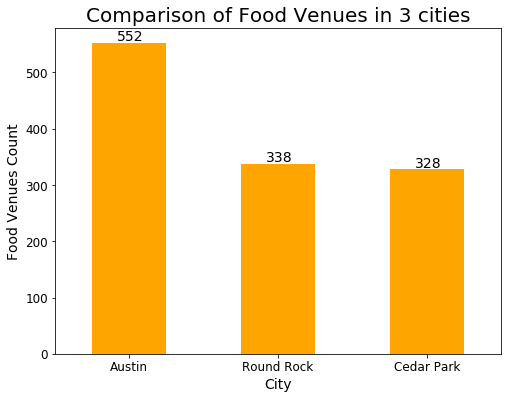

In [27]:
# plotting the food venues in three cities for comparison
ax = food_dataframe['CityName'].value_counts().plot(kind='bar', figsize=(8,6), fontsize=12, color='orange')
ax.set_xlabel("City", fontsize=14)
plt.xticks(rotation=0)
ax.set_ylabel("Food Venues Count", fontsize=14)
plt.title("Comparison of Food Venues in 3 cities", fontsize=20)

for i in ax.patches:
    ax.text(i.get_x()+.17, i.get_height()+4.0, str(i.get_height()), fontsize=14)

#### 3. Education

In [14]:
# creating a category list that has the category IDs of different education institutions
education_list = [
    "4d4b7105d754a06372d81259", "4f4533804b9074f6e4fb0105", "4f4533814b9074f6e4fb0106", 
    "4bf58dd8d48988d13d941735", "52e81612bcbc57f1066b7a45"]


# creating an empty dataframe to store the results
education_dataframe = pd.DataFrame(columns=["CityName", "Venue", "Latitude", "Longitude"])
venues_list = []
latitude_list = []
longitude_list = []
city_list = []

for city in range(3):
    for category in education_list:
        response = requests.get(requestPayload(top_city_df.loc[city, "Latitude"], top_city_df.loc[city, "Longitude"], category)).json()
        for i in range(len(response['response']['venues'])):
            venues_list.append(response['response']['venues'][i]['name'])
            latitude_list.append(response['response']['venues'][i]['location']['lat'])
            longitude_list.append(response['response']['venues'][i]['location']['lng'])
            city_list.append(top_city_df.loc[city, "CityName"])
            
education_dataframe["CityName"] = city_list
education_dataframe["Venue"] = venues_list
education_dataframe["Latitude"] = latitude_list
education_dataframe["Longitude"] = longitude_list

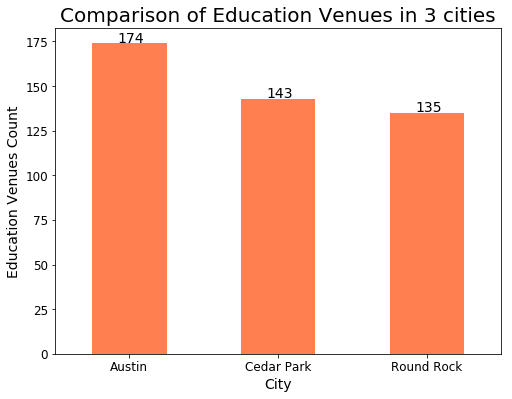

In [19]:
# plotting the education venues in three cities for comparison
ax = education_dataframe['CityName'].value_counts().plot(kind='bar', figsize=(8,6), fontsize=12, color='coral')
ax.set_xlabel("City", fontsize=14)
plt.xticks(rotation=0)
ax.set_ylabel("Education Venues Count", fontsize=14)
plt.title("Comparison of Education Venues in 3 cities", fontsize=20)

for i in ax.patches:
    ax.text(i.get_x()+.17, i.get_height()+0.6, str(i.get_height()), fontsize=14)

#### 4. Entertainment

In [5]:
# creating a category list that has the category IDs of the all venues related to Entertainment
entertainment_list = [
    "4bf58dd8d48988d1e4931735", "4bf58dd8d48988d17f941735", "4bf58dd8d48988d181941735", "4bf58dd8d48988d184941735", 
    "4d4b7105d754a06376d81259", "4bf58dd8d48988d11f941735"]

# creating an empty dataframe to store the results
entertainment_dataframe = pd.DataFrame(columns=["CityName", "Venue", "Latitude", "Longitude"])
venues_list = []
latitude_list = []
longitude_list = []
city_list = []

for city in range(3):
    for category in entertainment_list:
        response = requests.get(requestPayload(top_city_df.loc[city, "Latitude"], top_city_df.loc[city, "Longitude"], category)).json()
        for i in range(len(response['response']['venues'])):
            venues_list.append(response['response']['venues'][i]['name'])
            latitude_list.append(response['response']['venues'][i]['location']['lat'])
            longitude_list.append(response['response']['venues'][i]['location']['lng'])
            city_list.append(top_city_df.loc[city, "CityName"])
            
entertainment_dataframe["CityName"] = city_list
entertainment_dataframe["Venue"] = venues_list
entertainment_dataframe["Latitude"] = latitude_list
entertainment_dataframe["Longitude"] = longitude_list

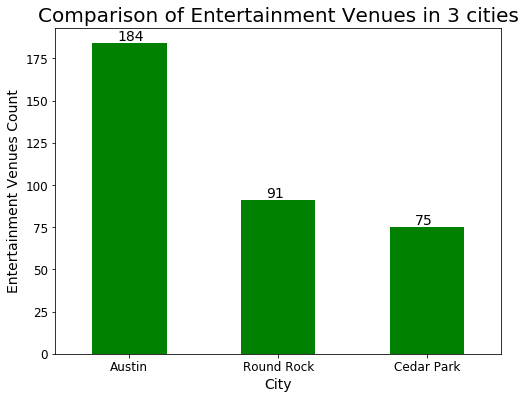

In [12]:
# plotting the entertainment venues in three cities for comparison
ax = entertainment_dataframe['CityName'].value_counts().plot(kind='bar', figsize=(8,6), fontsize=12, color='green')
ax.set_xlabel("City", fontsize=14)
plt.xticks(rotation=0)
ax.set_ylabel("Entertainment Venues Count", fontsize=14)
plt.title("Comparison of Entertainment Venues in 3 cities", fontsize=20)

for i in ax.patches:
    ax.text(i.get_x()+.17, i.get_height()+1.85, str(i.get_height()), fontsize=14)

#### 5. Average House Price

We can get the median pricing of a house in a certain area using this link from Zillow: https://www.zillow.com/{city}-{state}/home-values/. We will be using this link along with some parsing to get the median prices of the house and other details

In [259]:
# crafting the request payload to get the house's median price, 1-year change, and 1-year forecast
req_headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.8',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'
}

median_values = []
last_change = []
forecast = []

cities = ["austin", "round-rock", "cedar-park"]
for city in cities:
    url = "https://www.zillow.com/{}-tx/home-values/".format(city)
    response = requests.get(url, headers=req_headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    median = soup.find_all('h2')
    median_values.append(median[0].text)
    
    change_list = soup.find_all('ul', class_='zsg-g')
    list_item = change_list[0].find_all('li')
    last_change.append(list_item[0].text)    
    forecast.append(list_item[1].text.strip())
    
# converting the resultant data into a dataframe for easier analysis
home_value_dataframe = pd.DataFrame(columns=["City", "Last Year Value", "Current Median Value", "Next Year Forecast"])
home_value_dataframe["City"] = cities
home_value_dataframe["Last Year Value"] = last_change
home_value_dataframe["Current Median Value"] = median_values
home_value_dataframe["Next Year Forecast"] = forecast

home_value_dataframe

,City,Last Year Value,Current Median Value,Next Year Forecast
0,austin,6.2% 1-year change,"$370,700",3.4% 1-year forecast
1,round-rock,3.6% 1-year change,"$277,700",1.1% 1-year forecast
2,cedar-park,2.7% 1-year change,"$289,200",1.6% 1-year forecast


This dataframe is little difficult to plot with too many texts and '$', "\%" symbols floating around. Let us use regex and few mathematical formulae to clean this into a new dataframe

In [260]:
# creating two empty lists to store the sliced values 
new_ly_values = []
new_fc_values = []

# defining the regex pattern for remove the extra text in last year and forecast columns
percentage_regex = re.compile(r'\d+.\d+%')

# parsing through the column to find the patterns matching regex and adding it to the list
for values in home_value_dataframe['Last Year Value']:
    sliced_value = percentage_regex.search(values)
    new_ly_values.append(sliced_value.group())

for values in home_value_dataframe['Next Year Forecast']:
    sliced_value = percentage_regex.search(values)
    new_fc_values.append(sliced_value.group())

home_value_dataframe["Last Year Value"] = new_ly_values
home_value_dataframe["Next Year Forecast"] = new_fc_values
home_value_dataframe['Current Median Value'] = home_value_dataframe['Current Median Value'].str.replace("$", "")
home_value_dataframe['Current Median Value'] = home_value_dataframe['Current Median Value'].str.replace(",", "")


home_value_dataframe

,City,Last Year Value,Current Median Value,Next Year Forecast
0,austin,6.2%,370700,3.4%
1,round-rock,3.6%,277700,1.1%
2,cedar-park,2.7%,289200,1.6%


Still, this dataframe is not plot-able, so instead of last year value being a percentage, we will calculate those numbers exactly

In [261]:
# removing the "%" symbol for easier calculation
home_value_dataframe['Last Year Value'] = home_value_dataframe['Last Year Value'].str.replace("%","")
home_value_dataframe['Next Year Forecast'] = home_value_dataframe['Next Year Forecast'].str.replace("%","")

for i in range(len(home_value_dataframe)):
    last_percent = float(home_value_dataframe.loc[i, 'Last Year Value'])
    forecast = float(home_value_dataframe.loc[i, 'Next Year Forecast'])
    median_value = float(home_value_dataframe.loc[i, 'Current Median Value'])
    
    last = float(last_percent/100)
    fore = float(forecast/100)
    home_value_dataframe.loc[i, 'Last Year Value'] = (1 - last) * median_value
    home_value_dataframe.loc[i, 'Next Year Forecast'] = (1 + fore) * median_value


home_value_dataframe

,City,Last Year Value,Current Median Value,Next Year Forecast
0,austin,347717,370700,383304
1,round-rock,267703,277700,280755
2,cedar-park,281392,289200,293827
